In [180]:
import pandas as pd
import os 
import matplotlib.pyplot as plt
pd.options.plotting.backend = "plotly"

# Dataset Import

In [3]:
## Critère, Score et Date entre 2 vidéos
comparisons = pd.read_csv('../../Dataset/comparisons.csv')

## Trustscore des utilisateurs
users = pd.read_csv('../../Dataset/users.csv')

## Critère, Score et Droit des vidéos pour chaque utilisateurs
individual_criteria_scores = pd.read_csv('../../Dataset/individual_criteria_scores.csv')

## Critère et score de chaque vidéo
collective_criteria_scores = pd.read_csv('../../Dataset/collective_criteria_scores.csv')

# Data Visualisation

## Comparaison note générale et notes optionnels

In [181]:
all_criteria = collective_criteria_scores[['criteria', 'score']].groupby('criteria', as_index=False).mean()

<function matplotlib.pyplot.show(close=None, block=None)>

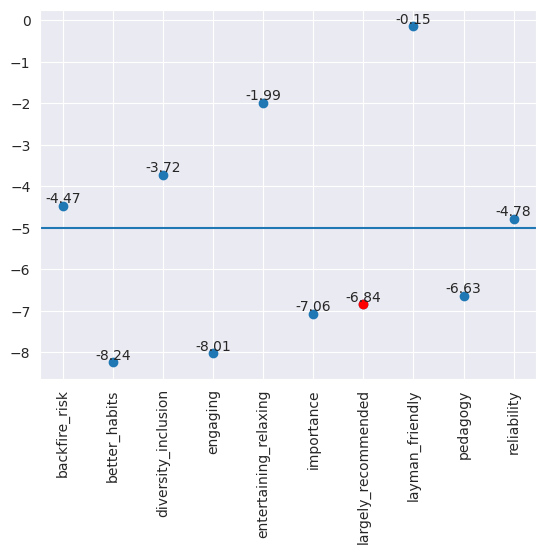

In [183]:
## Les points bleu représentent la note moyenne pour chaque critère optionnel
## Le point rouge représente la note moyenne générale
## La barre bleu représente la note moyenne de tous les critères optionnels
## On remarque que la note totale des critères optionnels ne correspond pas forcément à la note générale.

ax = plt.axes()
ax.scatter(all_criteria['criteria'], all_criteria['score'])
ax.scatter(all_criteria[all_criteria['criteria'] == 'largely_recommended']['criteria'], all_criteria[all_criteria['criteria'] == 'largely_recommended']['score'], color = 'red')
plt.axhline(np.nanmean(all_criteria[all_criteria['criteria'] != 'largely_recommended']['score']))
plt.xticks(rotation=90)
for (xi, yi) in zip(all_criteria['criteria'], all_criteria['score']):
    plt.text(xi, yi, round(yi,2), va='bottom', ha='center')
plt.show

## Evolution du nombre de vidéos comparées dans le temps

In [187]:
## Permet d'obtenir par date, les vidéos distinctes qui ont été comparées.

video_a = (comparisons[comparisons['criteria'] == 'largely_recommended'][['week_date', 'video_a']]
                .rename(columns = {'video_a':'video'}))

video_b = (comparisons[comparisons['criteria'] == 'largely_recommended'][['week_date', 'video_b']]
                .rename(columns = {'video_b':'video'}))

frames = [video_a, video_b]

video_time = pd.concat(frames).drop_duplicates()

video_time.head()

week_date        video
0   2023-01-09  xdk2Sargd3o
11  2023-01-09  SddHqBSHNmI
20  2022-09-05  lj_Gsq78VvA
39  2022-09-05  RilwnjDwTOc
52  2022-04-11  npNXJJzbpJI

In [197]:
## Plot de l'évolution du nombre de vidéos comparées dans le temps
video_time.groupby(['week_date']).count().plot(title='Evolution du nombre de vidéos comparées dans le temps')

## Cumul du nombre de vidéos comparées dans le temps

In [202]:
(video_time
    .sort_values('week_date')
    .drop_duplicates(subset=['video'])
    .groupby(['week_date'])
    .size().cumsum()
    .plot(title='Cumul du nombre de vidéos comparées dans le temps'))

## Note des vidéos en fonction de leur date de première notation

In [209]:
## Représente la date de première notation d'une vidéo

first_notation = video_time.sort_values('week_date').drop_duplicates(subset=['video']).reset_index(drop=True)


## Représente le score tournesol de chaque vidéo

video_score = (collective_criteria_scores
                .loc[collective_criteria_scores['criteria'] == 'largely_recommended'][['video', 'score']]
                .reset_index(drop=True))


## Merge des deux précédent. Représente pour chaque vidéo, son score et sa date de première notation

video_score_time = first_notation.merge(video_score, how='left', left_on='video', right_on='video')
video_score_time.head()

week_date        video  score
0  2021-01-11  VnyaAmM1nhE -36.00
1  2021-01-11  o4g6Jn2y_f4  32.34
2  2021-01-11  lG4VkPoG3ko  22.48
3  2021-01-11  RBEncgypGrU -35.63
4  2021-01-11  MG7Gl7YWZTg  18.53

In [214]:
video_score_time.plot(x="week_date", y="score", kind='scatter')

## Nombre de vidéos comparées en fonction de la date de première comparaison

In [223]:
## Représente le nombre de vidéo notée par utilisateur

nb_video = (comparisons[comparisons['criteria'] == 'largely_recommended'][['public_username', 'video_a']]
    .rename(columns = {'video_a':'video'})
    .drop_duplicates().reset_index(drop=True)
    .groupby(['public_username']).count().reset_index()
    .rename(columns = {"video":"nb_video"})
)



## Représente la date de première comparaison par utilisateur

date_inscription = (comparisons[['public_username', 'week_date']]
                        .groupby(['public_username']).min()
                        .reset_index()
                        .rename(columns={'week_date': 'première_comparaison'}))


## Merge des deux étapes précédentes. 
##Représente pour chaque utilisateur, le nombre de vidéos qu'il a noté, et sa date de première comparaison.

utilisateur_info = nb_video.merge(date_inscription, left_on='public_username', right_on='public_username')
utilisateur_info.head()

public_username  nb_video première_comparaison
0       +IAETICHS         5           2022-06-20
1       -Nicolas-         3           2022-09-26
2               0         2           2023-01-09
3           0-bit         2           2022-04-11
4        0b11stan         2           2022-09-05

In [230]:
utilisateur_info.plot.scatter('première_comparaison', 'nb_video', hover_data=['public_username'], title='Nombre de vidéos comparées en fonction de la date de première comparaison')

# API

In [141]:
import requests

BASE_URL = "https://api.tournesol.app"

session = requests.Session()
session.get(f"{BASE_URL}/stats").json()

{'active_users': {'total': 17192, 'joined_last_month': 717},
 'polls': [{'name': 'presidentielle2022',
   'compared_entities': {'total': 12, 'added_last_month': 0},
   'comparisons': {'total': 39823, 'added_last_month': 0}},
  {'name': 'videos',
   'compared_entities': {'total': 18705, 'added_last_month': 1297},
   'comparisons': {'total': 90091, 'added_last_month': 8566}}]}

In [17]:
##  Lister des vidéos en français publiées cette année à propos du climat, dont la durée est de moins de 3 minutes

response = session.get(
    f"{BASE_URL}/polls/videos/recommendations",
    params={
        "limit": 10,
        "search": "climat",
        "date_gte": "2023-01-01",
        "metadata[duration:lte:int]": 180,
        "metadata[language]": "fr",
        # "unsafe=true" will include videos that are not "safe" according to Tournesol,
        # because of a score too low or not enough contributions.
        "unsafe": "false",
    }
)
response.json()

{'count': 3,
 'next': None,
 'previous': None,
 'results': [{'uid': 'yt:Won4JyG9-QQ',
   'type': 'video',
   'n_comparisons': 28,
   'n_contributors': 16,
   'metadata': {'name': "Comment faire accepter les efforts d'adaptation face au changement climatique ? - Aurélien Barrau",
    'tags': ['écologie',
     'collapse',
     'effondrement',
     'environnement',
     'énergies',
     'économie',
     'politique',
     'science',
     'technologie',
     'pétrole',
     'pic de pétrole',
     'peak oil',
     'collapsologie',
     'humanité',
     'extinction',
     'anthropocène',
     'décroissance',
     'climat',
     'réchauffement climatique',
     'biodiversité',
     'co2',
     'giec',
     'réfugiés',
     'guerre',
     'ressources',
     'capitalisme',
     'urgence',
     'chaos',
     'ges',
     'pénurie',
     'jancovici',
     'cop21',
     'antarctique',
     'permafrost',
     'planète',
     'carbone',
     'scientifique',
     'france',
     'crise',
     'migration

In [18]:
## Récupérer les métadonnées d'une vidéo

youtube_video_id = "dQw4w9WgXcQ"
response = session.get(f"{BASE_URL}/polls/videos/entities/yt:{youtube_video_id}")
response.json()

{'uid': 'yt:dQw4w9WgXcQ',
 'type': 'video',
 'n_comparisons': 3,
 'n_contributors': 1,
 'metadata': {'name': 'Rick Astley - Never Gonna Give You Up (Official Music Video)',
  'tags': ['rick astley',
   'Never Gonna Give You Up',
   'nggyu',
   'never gonna give you up lyrics',
   'rick rolled',
   'Rick Roll',
   'rick astley official',
   'rickrolled',
   'Fortnite song',
   'Fortnite event',
   'Fortnite dance',
   'fortnite never gonna give you up',
   'rick roll',
   'rickrolling',
   'rick rolling',
   'never gonna give you up',
   '80s music',
   'rick astley new',
   'animated video',
   'rickroll',
   'meme songs',
   'never gonna give u up lyrics',
   'Rick Astley 2022',
   'never gonna let you down',
   'animated',
   'rick rolls 2022',
   'never gonna give you up karaoke'],
  'views': 1356355894,
  'source': 'youtube',
  'duration': 213,
  'language': 'en',
  'uploader': 'Rick Astley',
  'video_id': 'dQw4w9WgXcQ',
  'channel_id': 'UCuAXFkgsw1L7xaCfnd5JJOw',
  'description': 

In [142]:
## Lister les recommendations publiques d'un utilisateur

username = "le_science4all"
response = session.get(f"{BASE_URL}/users/{username}/recommendations/videos", params={
    "limit": 10,
    # "unsafe=false" (the default value) would exclude videos that are not "safe" according to Tournesol,
    # based on all users contributions, because of a score too low or not enough contributions.
    "unsafe": "true"
})
response.json()

{'count': 1162,
 'next': 'https://api.tournesol.app/users/le_science4all/recommendations/videos?limit=10&offset=10&unsafe=true',
 'previous': None,
 'results': [{'uid': 'yt:WPPPFqsECz0',
   'type': 'video',
   'n_comparisons': 400,
   'n_contributors': 106,
   'metadata': {'name': 'An Antidote to Dissatisfaction',
    'tags': ['Gratitude',
     'Dissatisfaction',
     'Happiness',
     'Happy',
     'Success',
     'Satisfaction',
     'Relationship',
     'Work',
     'Job',
     'Social Media',
     'Pop Culture',
     'Advertisement',
     'Attractiveness',
     'Beauty',
     'beautiful',
     'Self Improvement',
     'Positive Psychology',
     'Behavioural Psychology',
     'Behaviourism',
     'Behaviour Psychology',
     'Antidote',
     'Trait gratitude',
     'grateful',
     'gratefulness',
     'evolution',
     'reciprocity',
     'social',
     'society',
     'friendships',
     'loneliness',
     'Brain',
     'Envy',
     'Depression',
     'Trauma',
     'self help',


In [227]:
## Récupération via l'API du score de toutes les vidéos
## Pas utilisé car trop long + La donnée existe déjà


#BASE_URL = "https://api.tournesol.app"
#session = requests.Session()
#
#df['tournesol_score'] = ''
#
#for key, value in enumerate(df['video']):
#    youtube_video_id = value
#    response = session.get(f"{BASE_URL}/polls/videos/entities/yt:{youtube_video_id}")
#    score = response.json().get('tournesol_score')
#    
#    df['tournesol_score'][key] = score